# Which one is a better plan?

You work as an analyst for the telecom operator Megaline. The company offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans brings in more revenue in order to adjust the advertising budget.

You are going to carry out a preliminary analysis of the plans based on a relatively small client selection. You'll have the data on 500 Megaline clients: who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent in 2018. Your job is to analyze the clients' behavior and determine which prepaid plan brings in more revenue.

[We've provided you with some commentary to guide your thinking as you complete this project. However, make sure to remove all the bracketed comments before submitting your project.]

[Before you dive into analyzing your data, explain for yourself the purpose of the project and actions you plan to take.]

[Please bear in mind that studying, amending, and analyzing data is an iterative process. It is normal to return to previous steps and correct/expand them to allow for further steps.]

## Initialization

In [1]:

# Loading all the libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import math

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:,.2f}'.format)


## Load data

In [2]:
# Load the data files into different DataFrames

# In the TripleTen environment, datasets are usually stored in /datasets/
# We'll try a few common locations for robustness.
data_files = {
    'plans': ['megaline_plans.csv', '/datasets/megaline_plans.csv'],
    'users': ['megaline_users.csv', '/datasets/megaline_users.csv'],
    'calls': ['megaline_calls.csv', '/datasets/megaline_calls.csv'],
    'messages': ['megaline_messages.csv', '/datasets/megaline_messages.csv'],
    'internet': ['megaline_internet.csv', '/datasets/megaline_internet.csv'],
}

def read_first_existing(paths):
    for p in paths:
        try:
            return pd.read_csv(p)
        except FileNotFoundError:
            continue
    raise FileNotFoundError(f"None of these paths exist: {paths}")

plans_df = read_first_existing(data_files['plans'])
users_df = read_first_existing(data_files['users'])
calls_df = read_first_existing(data_files['calls'])
messages_df = read_first_existing(data_files['messages'])
internet_df = read_first_existing(data_files['internet'])

## Prepare the data

[The data for this project is split into several tables. Explore each one to get an initial understanding of the data. Do necessary corrections to each table if necessary.]

## Plans

In [3]:
# Print the general/summary information about the plans' DataFrame
plans_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [4]:
# Print a sample of data for plans

plans_df.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


[Describe what you see and notice in the general information and the printed data sample for the above price of data. Are there any issues (inappropriate data types, missing data etc) that may need further investigation and changes? How that can be fixed?]

## Fix data

[Fix obvious issues with the data given the initial observations.]

In [5]:
# Standardize plan name column (usually already fine)
if 'plan_name' in plans_df.columns:
    plans_df['plan_name'] = plans_df['plan_name'].astype(str)

# Sanity check: no negative rates / included amounts
numeric_cols = plans_df.select_dtypes(include='number').columns
if len(numeric_cols) > 0:
    assert (plans_df[numeric_cols] >= 0).all().all()
plans_df

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


## Enrich data

[Add additional factors to the data if you believe they might be useful.]

In [6]:
# Helpful derived columns (in GB instead of MB) for later revenue calculations
if 'mb_per_month_included' in plans_df.columns:
    plans_df['gb_per_month_included'] = plans_df['mb_per_month_included'] / 1024
plans_df

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included
0,50,15360,500,20,10,0.03,0.03,surf,15.00
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30.00


## Users

In [7]:
# Print the general/summary information about the users' DataFrame

users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [8]:
# Print a sample of data for users
users_df.head()


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


[Describe what you see and notice in the general information and the printed data sample for the above price of data. Are there any issues (inappropriate data types, missing data etc) that may need further investigation and changes? How that can be fixed?]

### Fix Data

[Fix obvious issues with the data given the initial observations.]

In [9]:
# Convert dates to datetime
for col in ['reg_date', 'churn_date']:
    if col in users_df.columns:
        users_df[col] = pd.to_datetime(users_df[col], errors='coerce')

# Ensure plan is string/categorical
if 'plan' in users_df.columns:
    users_df['plan'] = users_df['plan'].astype(str)

# Extract state from 'city' (format like 'New York-Newark-Jersey City, NY-NJ-PA')
if 'city' in users_df.columns:
    users_df['state'] = users_df['city'].str.extract(r',\s*([A-Z]{2})', expand=False)


### Enrich Data

[Add additional factors to the data if you believe they might be useful.]

In [10]:
# Add registration month (useful for cohorting if needed)
if 'reg_date' in users_df.columns:
    users_df['reg_month'] = users_df['reg_date'].dt.to_period('M')
users_df.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,state,reg_month
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT,GA,2018-12
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,WA,2018-08
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaT,NV,2018-10
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaT,OK,2018-01
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaT,WA,2018-05


## Calls

In [11]:
# Print the general/summary information about the calls' DataFrame
calls_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [12]:
# Print a sample of data for calls
calls_df.head()


,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


[Describe what you see and notice in the general information and the printed data sample for the above price of data. Are there any issues (inappropriate data types, missing data etc) that may need further investigation and changes? How that can be fixed?]

### Fix data

[Fix obvious issues with the data given the initial observations.]

In [13]:
# Convert date column to datetime
if 'call_date' in calls_df.columns:
    calls_df['call_date'] = pd.to_datetime(calls_df['call_date'], errors='coerce')

# In this project, each started minute counts as a full minute billed.
# So we round call duration UP to the nearest integer.
if 'duration' in calls_df.columns:
    calls_df['duration'] = np.ceil(calls_df['duration']).astype('int')

# Add month for monthly aggregation
calls_df['month'] = calls_df['call_date'].dt.to_period('M')

### Enrich data

[Add additional factors to the data if you believe they might be useful.]

In [14]:
# Quick checks
calls_df.isna().mean().sort_values(ascending=False).head(10)

id          0.00
user_id     0.00
call_date   0.00
duration    0.00
month       0.00
dtype: float64

## Messages

In [15]:
# Print the general/summary information about the messages' DataFrame
messages_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [16]:
# Print a sample of data for messages

messages_df.head()

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


[Describe what you see and notice in the general information and the printed data sample for the above price of data. Are there any issues (inappropriate data types, missing data etc) that may need further investigation and changes? How that can be fixed?]

### Fix data

[Fix obvious issues with the data given the initial observations.]

In [17]:
# Convert date column to datetime and add month
if 'message_date' in messages_df.columns:
    messages_df['message_date'] = pd.to_datetime(messages_df['message_date'], errors='coerce')
messages_df['month'] = messages_df['message_date'].dt.to_period('M')

### Enrich data

[Add additional factors to the data if you believe they might be useful.]

In [18]:
# Nothing else critical to enrich here, but we keep a clean view
messages_df.head()

,id,user_id,message_date,month
0,1000_125,1000,2018-12-27,2018-12
1,1000_160,1000,2018-12-31,2018-12
2,1000_223,1000,2018-12-31,2018-12
3,1000_251,1000,2018-12-27,2018-12
4,1000_255,1000,2018-12-26,2018-12


## Internet

In [19]:
# Print the general/summary information about the internet DataFrame
internet_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [20]:
# Print a sample of data for the internet traffic
internet_df.head()


,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


[Describe what you see and notice in the general information and the printed data sample for the above price of data. Are there any issues (inappropriate data types, missing data etc) that may need further investigation and changes? How that can be fixed?]

### Fix data

[Fix obvious issues with the data given the initial observations.]

In [21]:
# Convert date column to datetime and add month
if 'session_date' in internet_df.columns:
    internet_df['session_date'] = pd.to_datetime(internet_df['session_date'], errors='coerce')
internet_df['month'] = internet_df['session_date'].dt.to_period('M')


### Enrich data

[Add additional factors to the data if you believe they might be useful.]

In [22]:
# Internet is provided in MB in the dataset; for billing we will convert to GB later (rounded up).
# Keep both columns for convenience.
if 'mb_used' in internet_df.columns:
    internet_df['gb_used'] = internet_df['mb_used'] / 1024
internet_df.head()

,id,user_id,session_date,mb_used,month,gb_used
0,1000_13,1000,2018-12-29,89.86,2018-12,0.09
1,1000_204,1000,2018-12-31,0.00,2018-12,0.00
2,1000_379,1000,2018-12-28,660.40,2018-12,0.64
3,1000_413,1000,2018-12-26,270.99,2018-12,0.26
4,1000_442,1000,2018-12-27,880.22,2018-12,0.86


## Study plan conditions

[It is critical to understand how the plans work, how users are charged based on their plan subscription. So, we suggest printing out the plan information to view their conditions once again.]

In [23]:
# Print out the plan conditions and make sure they are clear for you

plans_df

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included
0,50,15360,500,20,10,0.03,0.03,surf,15.00
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30.00


## Aggregate data per user

[Now, as the data is clean, aggregate data per user per period in order to have just one record per user per period. It should ease the further analysis a lot.]

In [24]:
# Calculate the number of calls made by each user per month. Save the result.

calls_per_month = (
    calls_df
    .groupby(['user_id', 'month'])
    .agg(calls_count=('id', 'count'))
    .reset_index()
)
calls_per_month.head()

,user_id,month,calls_count
0,1000,2018-12,16
1,1001,2018-08,27
2,1001,2018-09,49
3,1001,2018-10,65
4,1001,2018-11,64


In [25]:
# Calculate the amount of minutes spent by each user per month. Save the result.

minutes_per_month = (
    calls_df
    .groupby(['user_id', 'month'])
    .agg(minutes_used=('duration', 'sum'))
    .reset_index()
)
minutes_per_month.head()


,user_id,month,minutes_used
0,1000,2018-12,124
1,1001,2018-08,182
2,1001,2018-09,315
3,1001,2018-10,393
4,1001,2018-11,426


In [26]:
# Calculate the number of messages sent by each user per month. Save the result.
messages_per_month = (
    messages_df
    .groupby(['user_id', 'month'])
    .agg(messages_count=('id', 'count'))
    .reset_index()
)
messages_per_month.head()


,user_id,month,messages_count
0,1000,2018-12,11
1,1001,2018-08,30
2,1001,2018-09,44
3,1001,2018-10,53
4,1001,2018-11,36


In [27]:
# Calculate the volume of internet traffic used by each user per month. Save the result.
internet_per_month = (
    internet_df
    .groupby(['user_id', 'month'])
    .agg(mb_used=('mb_used', 'sum'))
    .reset_index()
)
internet_per_month.head()


,user_id,month,mb_used
0,1000,2018-12,"1,901.47"
1,1001,2018-08,"6,919.15"
2,1001,2018-09,"13,314.82"
3,1001,2018-10,"22,330.49"
4,1001,2018-11,"18,504.30"


[Put the aggregate data together into one DataFrame so that one record in it would represent what an unique user consumed in a given month.]

In [28]:
# Merge the data for calls, minutes, messages, internet based on user_id and month
# Merge monthly usage into a single table (outer joins to keep months with partial activity)
usage_df = calls_per_month.merge(minutes_per_month, on=['user_id','month'], how='outer')
usage_df = usage_df.merge(messages_per_month, on=['user_id','month'], how='outer')
usage_df = usage_df.merge(internet_per_month, on=['user_id','month'], how='outer')

# Replace missing usage with 0
for col in ['calls_count', 'minutes_used', 'messages_count', 'mb_used']:
    if col in usage_df.columns:
        usage_df[col] = usage_df[col].fillna(0).astype('int')

usage_df.head()


,user_id,month,calls_count,minutes_used,messages_count,mb_used
0,1000,2018-12,16,124,11,1901
1,1001,2018-08,27,182,30,6919
2,1001,2018-09,49,315,44,13314
3,1001,2018-10,65,393,53,22330
4,1001,2018-11,64,426,36,18504


In [29]:
# Add the plan information
# Add plan + geography info from users
usage_df = usage_df.merge(
    users_df[['user_id', 'plan', 'city', 'state']],
    on='user_id',
    how='left'
)

# Add plan pricing details
usage_df = usage_df.merge(
    plans_df,
    left_on='plan',
    right_on='plan_name',
    how='left'
)
usage_df.head()


,user_id,month,calls_count,minutes_used,messages_count,mb_used,plan,city,state,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included
0,1000,2018-12,16,124,11,1901,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA",GA,1000,30720,3000,70,7,0.01,0.01,ultimate,30.00
1,1001,2018-08,27,182,30,6919,surf,"Seattle-Tacoma-Bellevue, WA MSA",WA,50,15360,500,20,10,0.03,0.03,surf,15.00
2,1001,2018-09,49,315,44,13314,surf,"Seattle-Tacoma-Bellevue, WA MSA",WA,50,15360,500,20,10,0.03,0.03,surf,15.00
3,1001,2018-10,65,393,53,22330,surf,"Seattle-Tacoma-Bellevue, WA MSA",WA,50,15360,500,20,10,0.03,0.03,surf,15.00
4,1001,2018-11,64,426,36,18504,surf,"Seattle-Tacoma-Bellevue, WA MSA",WA,50,15360,500,20,10,0.03,0.03,surf,15.00


[Calculate the monthly revenue from each user (subtract the free package limit from the total number of calls, text messages, and data; multiply the result by the calling plan value; add the monthly charge depending on the calling plan). N.B. This might not be as trivial as just a couple of lines given the plan conditions! So, it's okay to spend some time on it.]

In [30]:
# Calculate the monthly revenue for each user

# Revenue calculation per user-month
def compute_revenue(row):
    # Included amounts
    included_minutes = row.get('minutes_included', 0)
    included_messages = row.get('messages_included', 0)
    included_mb = row.get('mb_per_month_included', 0)

    # Usage
    minutes = row.get('minutes_used', 0)
    messages = row.get('messages_count', 0)
    mb = row.get('mb_used', 0)

    # Overages
    extra_minutes = max(0, minutes - included_minutes)
    extra_messages = max(0, messages - included_messages)

    # Data billed in GB rounded up
    gb_used = math.ceil(mb / 1024) if mb > 0 else 0
    gb_included = included_mb / 1024
    extra_gb = max(0, gb_used - gb_included)

    # Charges
    monthly_fee = row.get('usd_monthly_fee', 0)
    rev = monthly_fee
    rev += extra_minutes * row.get('usd_per_minute', 0)
    rev += extra_messages * row.get('usd_per_message', 0)
    rev += extra_gb * row.get('usd_per_gb', 0)
    return rev

usage_df['revenue'] = usage_df.apply(compute_revenue, axis=1)
usage_df[['user_id','month','plan','minutes_used','messages_count','mb_used','revenue']].head()


,user_id,month,plan,minutes_used,messages_count,mb_used,revenue
0,1000,2018-12,ultimate,124,11,1901,0.00
1,1001,2018-08,surf,182,30,6919,0.00
2,1001,2018-09,surf,315,44,13314,0.00
3,1001,2018-10,surf,393,53,22330,70.09
4,1001,2018-11,surf,426,36,18504,40.00


## Study user behaviour

[Calculate some useful descriptive statistics for the aggregated and merged data, which typically reveal an overall picture captured by the data. Draw useful plots to help the understanding. Given that the main task is to compare the plans and decide on which one is more profitable, the statistics and the plots should be calculated on a per-plan basis.]

[There are relevant hints in the comments for Calls but they are not provided for Messages and Internet though the principle of statistical study is the same for them as for Calls.]

### Calls

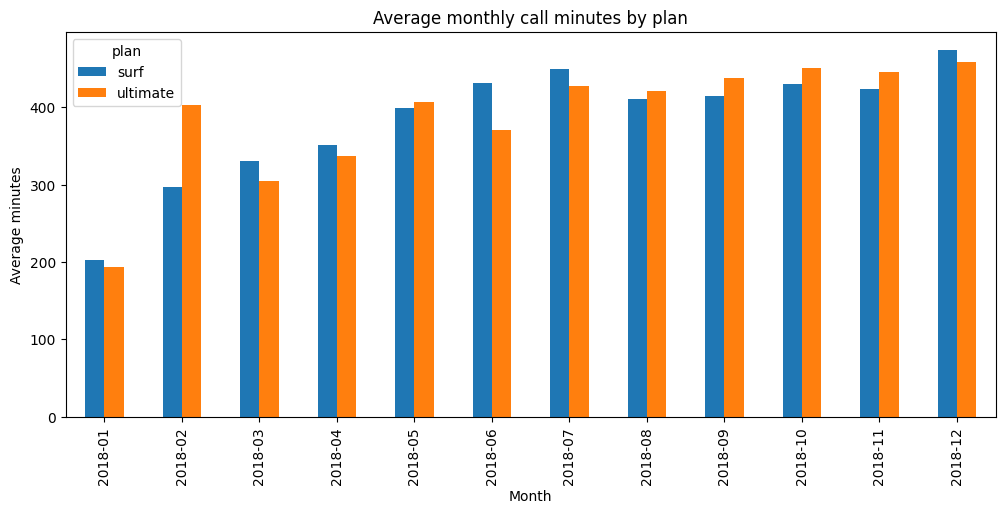

In [31]:
# Compare average duration of calls per each plan per each distinct month. Plot a bar plat to visualize it.
avg_call_duration = (
    usage_df
    .groupby(['month','plan'])['minutes_used']
    .mean()
    .unstack(fill_value=0)
)

avg_call_duration.plot(kind='bar', figsize=(12,5))
plt.title('Average monthly call minutes by plan')
plt.xlabel('Month')
plt.ylabel('Average minutes')
plt.show()


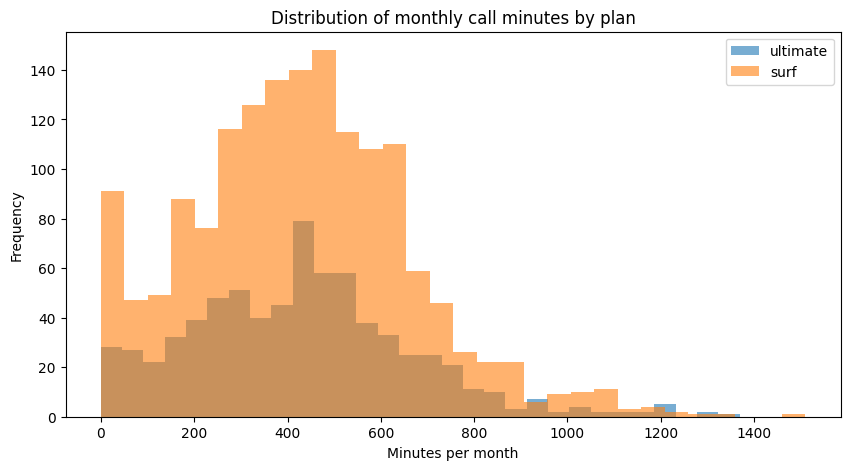

In [32]:
# Compare the number of minutes users of each plan require each month. Plot a histogram.
# Histogram of monthly minutes by plan
for plan in usage_df['plan'].dropna().unique():
    usage_df.loc[usage_df['plan'] == plan, 'minutes_used'].plot(kind='hist', bins=30, alpha=0.6, label=plan, figsize=(10,5))
plt.title('Distribution of monthly call minutes by plan')
plt.xlabel('Minutes per month')
plt.ylabel('Frequency')
plt.legend()
plt.show()


[Calculate the mean and the variable of the call duration to reason on whether users on the different plans have different behaviours for their calls.]

In [33]:
# Calculate the mean and the variance of the monthly call duration
call_stats = usage_df.groupby('plan')['minutes_used'].agg(['mean','var','std','median'])
call_stats

,mean,var,std,median
plan,,,,
surf,428.75,"54,968.28",234.45,425
ultimate,430.45,"57,844.46",240.51,424


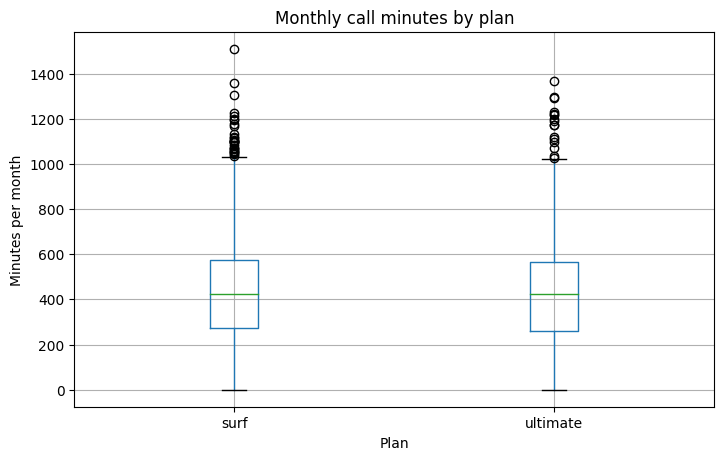

In [34]:
# Plot a boxplot to visualize the distribution of the monthly call duration
usage_df.boxplot(column='minutes_used', by='plan', figsize=(8,5))
plt.title('Monthly call minutes by plan')
plt.suptitle('')
plt.xlabel('Plan')
plt.ylabel('Minutes per month')
plt.show()


[Formulate conclusions on how the users behave in terms of calling. Is their behaviour different between the plans?]

### Messages

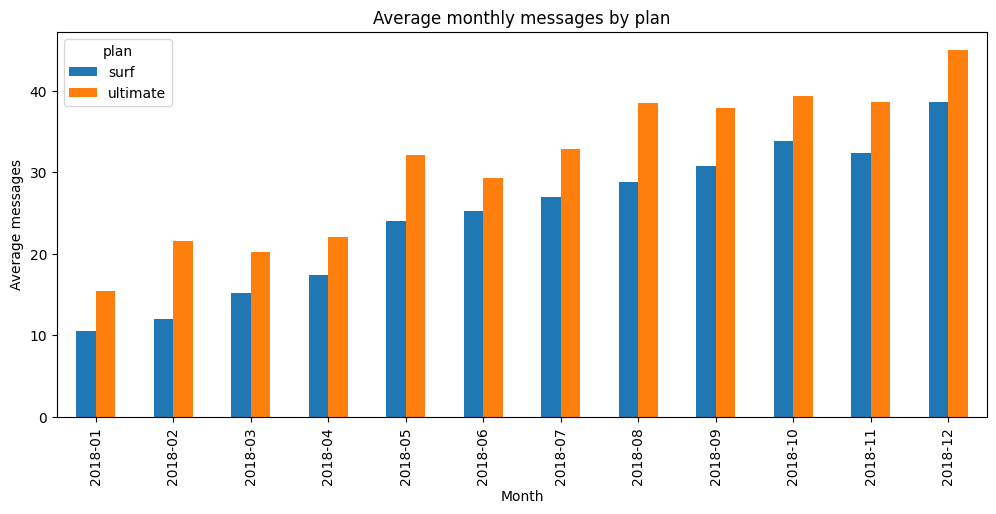

In [35]:
# Compare the number of messages users of each plan tend to send each month

msg_by_month = (
    usage_df
    .groupby(['month','plan'])['messages_count']
    .mean()
    .unstack(fill_value=0)
)
msg_by_month.plot(kind='bar', figsize=(12,5))
plt.title('Average monthly messages by plan')
plt.xlabel('Month')
plt.ylabel('Average messages')
plt.show()

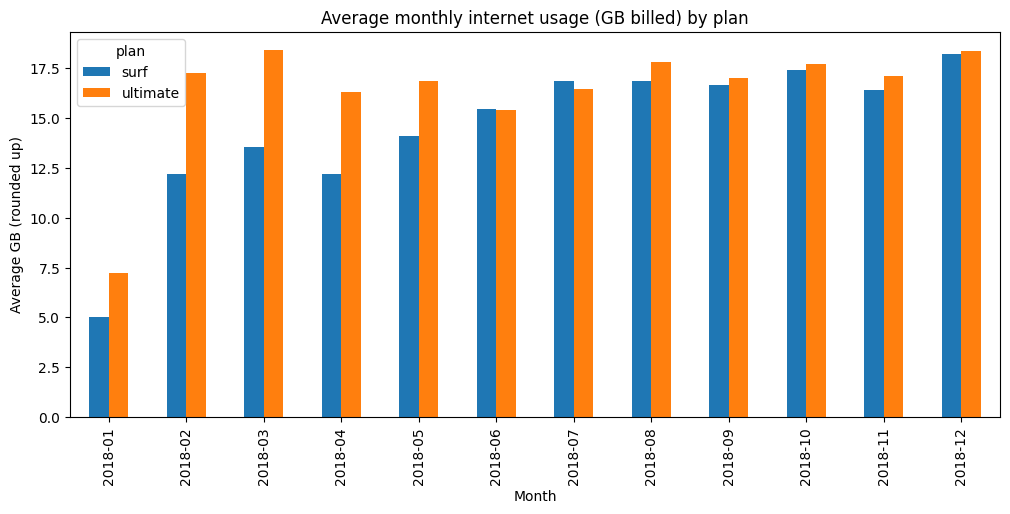

In [36]:
# Compare the amount of internet traffic consumed by users per plan
internet_by_month = (
    usage_df
    .assign(gb_billed=np.ceil(usage_df['mb_used'] / 1024))
    .groupby(['month','plan'])['gb_billed']
    .mean()
    .unstack(fill_value=0)
)
internet_by_month.plot(kind='bar', figsize=(12,5))
plt.title('Average monthly internet usage (GB billed) by plan')
plt.xlabel('Month')
plt.ylabel('Average GB (rounded up)')
plt.show()


In [37]:
msg_stats = usage_df.groupby('plan')['messages_count'].agg(['mean','var','std','median'])
internet_stats = usage_df.assign(gb_billed=np.ceil(usage_df['mb_used'] / 1024)).groupby('plan')['gb_billed'].agg(['mean','var','std','median'])
display(msg_stats)
display(internet_stats)

,mean,var,std,median
plan,,,,
surf,31.16,"1,126.72",33.57,24
ultimate,37.55,"1,208.76",34.77,30


,mean,var,std,median
plan,,,,
surf,16.67,61.59,7.85,17.00
ultimate,17.31,58.83,7.67,17.00


[Formulate conclusions on how the users behave in terms of messaging. Is their behaviour different between the plans?]

### Internet

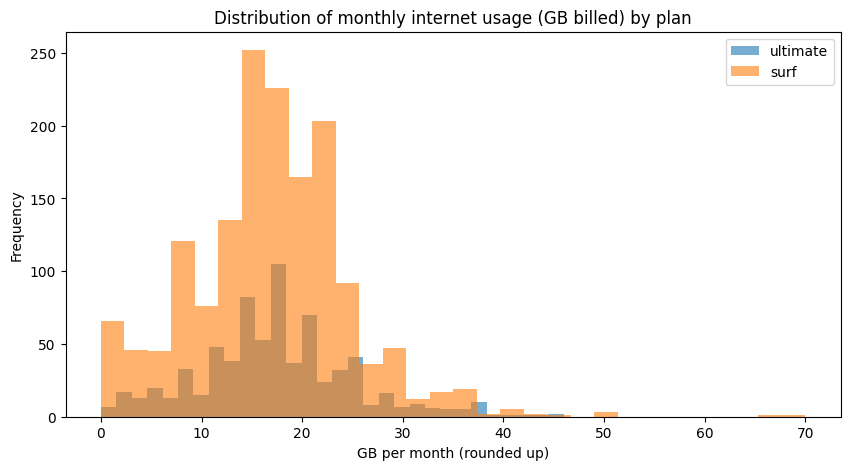

In [38]:
# Distribution of monthly internet traffic by plan (GB billed)
usage_df = usage_df.assign(gb_billed=np.ceil(usage_df['mb_used'] / 1024))
for plan in usage_df['plan'].dropna().unique():
    usage_df.loc[usage_df['plan'] == plan, 'gb_billed'].plot(kind='hist', bins=30, alpha=0.6, label=plan, figsize=(10,5))
plt.title('Distribution of monthly internet usage (GB billed) by plan')
plt.xlabel('GB per month (rounded up)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [39]:
internet_stats

,mean,var,std,median
plan,,,,
surf,16.67,61.59,7.85,17.00
ultimate,17.31,58.83,7.67,17.00


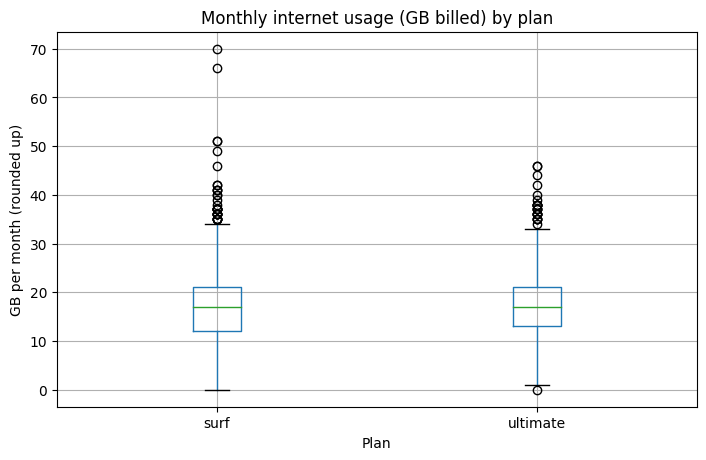

In [40]:
usage_df.boxplot(column='gb_billed', by='plan', figsize=(8,5))
plt.title('Monthly internet usage (GB billed) by plan')
plt.suptitle('')
plt.xlabel('Plan')
plt.ylabel('GB per month (rounded up)')
plt.show()

[Formulate conclusions on how the users tend to consume the internet traffic? Is their behaviour different between the plans?]

## Revenue

[Likewise you have studied the user behaviour, statistically describe the revenue between the plans.]

In [41]:
revenue_stats = usage_df.groupby('plan')['revenue'].agg(['mean','var','std','median','count'])
revenue_stats

,mean,var,std,median,count
plan,,,,,
surf,40.69,"3,066.37",55.37,20.36,1573
ultimate,2.31,129.85,11.40,0.00,720


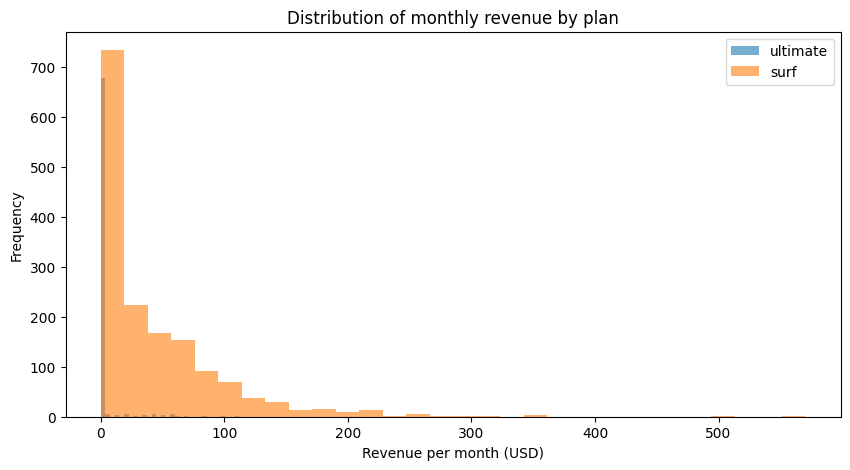

In [42]:
for plan in usage_df['plan'].dropna().unique():
    usage_df.loc[usage_df['plan'] == plan, 'revenue'].plot(kind='hist', bins=30, alpha=0.6, label=plan, figsize=(10,5))
plt.title('Distribution of monthly revenue by plan')
plt.xlabel('Revenue per month (USD)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

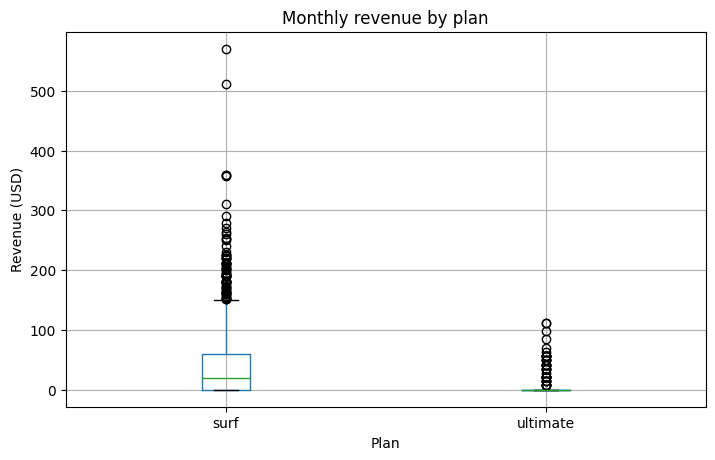

In [43]:
usage_df.boxplot(column='revenue', by='plan', figsize=(8,5))
plt.title('Monthly revenue by plan')
plt.suptitle('')
plt.xlabel('Plan')
plt.ylabel('Revenue (USD)')
plt.show()

[Formulate conclusions about how the revenue differs between the plans.]

## Test statistical hypotheses

[Test the hypothesis that the average revenue from users of the Ultimate and Surf calling plans differs.]

[Formulate the null and the alternative hypotheses, choose the statistical test, decide on the alpha value.]

In [44]:
# Test the hypotheses

# H0: average revenue for Surf == average revenue for Ultimate
# H1: average revenue for Surf != average revenue for Ultimate
alpha = 0.05

surf_rev = usage_df.loc[usage_df['plan'].str.lower() == 'surf', 'revenue']
ultimate_rev = usage_df.loc[usage_df['plan'].str.lower() == 'ultimate', 'revenue']

results = stats.ttest_ind(surf_rev, ultimate_rev, equal_var=False, nan_policy='omit')
print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Reject H0: the average revenues differ between plans.')
else:
    print('Fail to reject H0: no evidence that the average revenues differ.')

p-value: 1.1755398803902691e-129
Reject H0: the average revenues differ between plans.


[Test the hypothesis that the average revenue from users in the NY-NJ area is different from that of the users from the other regions.]

[Formulate the null and the alternative hypotheses, choose the statistical test, decide on the alpha value.]

In [45]:
# Test the hypotheses

# H0: average revenue in NY-NJ area == average revenue in other regions
# H1: average revenue in NY-NJ area != average revenue in other regions
alpha = 0.05

# Define NY-NJ area using state code 'NY' or 'NJ' (based on dataset 'city, ST-..' format)
ny_nj_rev = usage_df.loc[usage_df['state'].isin(['NY', 'NJ']), 'revenue']
other_rev = usage_df.loc[~usage_df['state'].isin(['NY', 'NJ']), 'revenue']

results = stats.ttest_ind(ny_nj_rev, other_rev, equal_var=False, nan_policy='omit')
print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Reject H0: the average revenues differ between NY-NJ and other regions.')
else:
    print('Fail to reject H0: no evidence that the average revenues differ between regions.')


p-value: 0.043209957987121156
Reject H0: the average revenues differ between NY-NJ and other regions.


## General conclusion

[List your important conclusions in this final section, make sure they cover all those important decisions (assumptions) that you've made and that led you to the way you processed and analyzed the data.]